In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

## Pathing

In [2]:
maindatapath = "../OSC-measuresments/"

oscpaths = [maindatapath + osc +"/" for osc in  os.listdir(maindatapath) if osc[-4:]!=".jpg"] # the paths to the folders of the samples

cellpaths = lambda osc : [ oscpaths[osc] + cell + "/" for cell in os.listdir(oscpaths[osc]) ]

measurementpaths = lambda osc, cell : [cellpaths(osc)[cell] + measurement for measurement in os.listdir(cellpaths(osc)[cell])]

measurement = lambda osc,cell,mm : np.loadtxt(measurementpaths(osc,cell)[mm], skiprows=1).T

print(measurement(0,0,0).shape)

(2, 201)


In [24]:
for i in range(len(oscpaths)):
    print(str(i) + ": "+oscpaths[i])

0: ../OSC-measuresments/OSC1/
1: ../OSC-measuresments/OSC2/
2: ../OSC-measuresments/OSC3/
3: ../OSC-measuresments/OSC4/
4: ../OSC-measuresments/OSC5/
5: ../OSC-measuresments/PatrickOSC/
6: ../OSC-measuresments/ReraSC/


## Cutting down Measurements to 4th quadrant

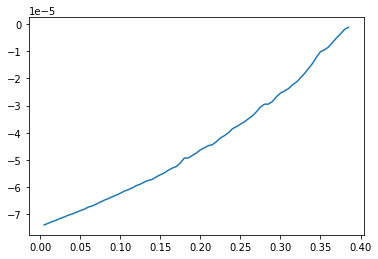

In [3]:
#measurementrelevant = lambda osc, cell, mm : np.where(measurement(osc,cell,mm)*np.array([[1],[-1]])>0,measurement(osc,cell,mm),0)
measurementrelevant = lambda osc, cell, mm : measurement(osc,cell,mm)[ : ,  np.where( np.all ( measurement(osc,cell,mm)*np.array([[1],[-1]])>0 , axis =(0)))[0] ] 
    # ^ slices the array down to all the pairs where the voltage is positive and the current is negative
mmr1 = measurementrelevant(0,0,2)
plt.plot(mmr1[0],mmr1[1])

## Interpolation

In [64]:
def interpolate(mat, witherrors=False):
    x1,x2 = mat[0]
    y1,y2 = mat[1]
    x0 = (y1*x2-y2*x1)/(y1-y2)
    return x0

def j0error(mat,jerr):
    x1,x2 = mat[0]
    y1,y2 = mat[1]
    return np.sqrt(1/(x1-x2)**2*(x1**2*jerr[1]+x1**2*jerr[0]))

def v0error(mat,jerr,v0):
    x1,x2 = mat[0]
    y1,y2 = mat[1]
    return 1/(y1-y2)**2*( (x2-v0)**2*jer[0]**2 + (x1-v0)**2*jerr[1]**2 )

def find_zeros(mm,jerr = False):
    V = mm[0]
    J = mm[1]
    jscindeces = [np.where(V<0)[0][-1],np.where(V>0)[0][0]]
    vocindeces = [np.where(J<0)[0][-1],np.where(J>0)[0][0]]
    jsc = interpolate(np.array([[0,1],[1,0]])@mm[:,jscindeces]) # the matrix mult is to swap the voltage and current
    voc = interpolate(mm[:,vocindeces])
    if jerr:
        jscerr = j0error(mm[:,jscindeces],jerr[jscindeces])
        vocerr = v0error(mm[:,vocindeces],jerr[vocindeces],voc)
    else:
        jscerr = 0
        vocerr = 0
    return [jsc,jscerr], [voc,vocerr], jscindeces, vocindeces

def power_curve(mmr): 
    V,j = mmr
    P = V*np.abs(j)
    return P

def max_Power(mmr,jerr=False):
    Pcurve = power_curve(mmr)
    Pmax = np.max(Pcurve)
    index = np.where(Pcurve == Pmax)[0][0]
    if jerr:
        Pmaxerr = mmr[0][index]*jerr[index]
    else:
        Pmaxerr = 0
    return [Pmax,Pmaxerr],Pcurve,index

def FF(Pmax,voc,jsc):
    FFactor = Pmax/(voc[0]*jsc[0])
    FFerr = np.sqrt(FF**2*((voc[1]/voc[0])**2 + (jsc[1]/jsc[0])**2 + (Pmax[1]/Pmax[0])**2))
    return [FFactor,FFerr]

def jm(mms,xi):
    js = mms[:,1]
    N = js.shape[0]
    jmean = np.mean(js,axis=0)
    std = np.std(js,axis = 0,ddof=1)
    jerr = np.sqrt((std/N)**2+(jmean*xi)**2)
    return np.array([mms[0,0],jmean]),jerr

measurement1 = measurement(0,0,1)

find_zeros(measurement1)

IndentationError: expected an indented block (<ipython-input-64-3bc0b95f9f6b>, line 49)

In [55]:
test = np.array([[range(10),range(10,20)],[range(10),range(11,21)]])
jm(test,5)

(array([[ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. ],
        [10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]]),
 array([52.50476169, 57.50434766, 62.50399987, 67.5037036 , 72.50344819,
        77.50322574, 82.50303025, 87.5028571 , 92.50270266, 97.50256407]))

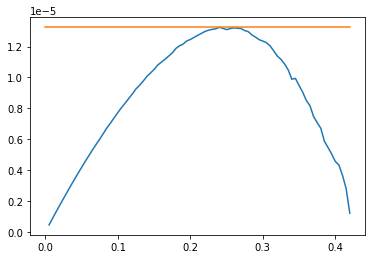

In [63]:
mr1 = measurementrelevant(0,0,1)
power1 = power_curve(mr1)
plt.plot(mr1[0],power1)
plt.plot([0,mr1[0][-1]],2*[max_Power(mr1)[0][0]])

### Average Ratio between uncertainty in Area and Area

In [29]:
Areas = [[[59.98179058129378, 2.037060072502754],[63.18271304356203, 2.1294542343052365]],
[[58.381291409049226, 1.9911392100260337],[63.18271304356203, 2.1294542343052365],[59.18154437079939, 2.0140753032092644],[59.18154437079939, 2.0140753032092644]],
[[79.18620659205573, 2.5551844803038914],[83.50692025087656, 2.6861549355950944],[64.30301420466873, 2.107965006349283],[59.98179058129378, 1.9796650709022352],
[64.94318163083341, 2.1270430696405636]]] # [OSC1,OSC3,OSC5]
avxi=[]
for i in range(len(Areas)):
    avxii=0
    for j in range(len(Areas[i])):
        avxii+=Areas[i][j][1]/Areas[i][j][0]
    avxi.append(avxii/len(Areas[i]))
avxi

[0.033832211493689125, 0.033968298464789964, 0.03259469058814808]

$u_j = j\cdot \xi,\quad \xi = \frac{u_A}{A}$<p>
$u_{\overline{j},\text{sys}}\approx \overline{j}\cdot \xi$

In [48]:
np.array([[[1,1],[22,2]],[[1,1],[22,2]]])[:,1]

array([[22,  2],
       [22,  2]])

### OSC 1

In [73]:
osc1cell1mms = len(measurementpaths(0,0))
OSC1CELL1 = np.empty((osc1cell1mms,*measurement(0,0,0).shape))

for i in range(len(measurementpaths(0,0))):
    OSC1CELL1[i] = measurement(0,0,i)



## Plotting

In [66]:
plt.rcParams.update({
    "figure.autolayout": True,
    "text.usetex": True,
    "font.family": "serif"})

matplotlib.rc("xtick", labelsize=14)
matplotlib.rc("ytick", labelsize=14)
    

1